In [2]:
import pandas as pd

sales_data = pd.read_csv('.\datasets\supermarket_sales.csv')

In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

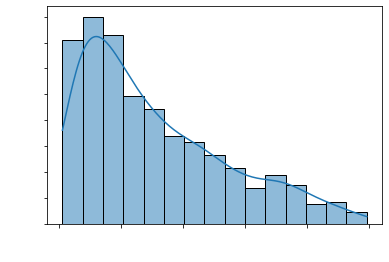

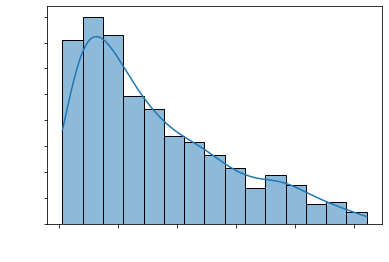

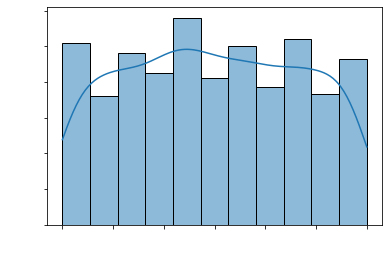

In [4]:
## WHAT IS THE DISTRIBUTION OF THE COGS, RATING, AND TOTAL COLUMN? ##
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(sales_data['cogs'], kde=True)
plt.xlabel('COGS', color='white')
plt.ylabel('COUNT', color='white')
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')

plt.figure()
sns.histplot(sales_data['Total'], kde=True)
plt.xlabel('TOTAL', color='white')
plt.ylabel('COUNT', color='white')
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')

plt.figure()
sns.histplot(sales_data['Rating'], kde = True)
plt.xlabel('RATING',color='white')
plt.ylabel('COUNT', color='white')
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')

plt.show()


In [5]:
## Lets try to fit COGS first ##

from scipy import stats

cogs = sales_data['cogs']

sigma, loc_log, scale_log = stats.lognorm.fit(cogs)

shape, loc_gamma, scale_gamma = stats.gamma.fit(cogs)

a, b, loc_beta, scale_beta = stats.beta.fit(cogs)

cogs_mean = cogs.mean()
cogs_std = cogs.std()

In [6]:
## Use the Kolmogorov-Smirnov Test to find the best fit ##

lognormal_test = stats.kstest(cogs, stats.lognorm.cdf, args=(sigma, loc_log, scale_log))
gamma_test = stats.kstest(cogs, stats.gamma.cdf, args=(shape, loc_gamma, scale_gamma))
beta_test = stats.kstest(cogs, stats.beta.cdf, args=(a,b,loc_beta,scale_beta))
poisson_test = stats.kstest(cogs, stats.poisson.cdf, args=(cogs_mean,))

print(f'Lognormal GOF: {lognormal_test.statistic}')
print(f'Gamma GOF: {gamma_test.statistic}')
print(f'Beta GOF: {beta_test.statistic}')
print(f'Poisson GOF: {poisson_test.statistic}')

Lognormal GOF: 0.6215067641644486
Gamma GOF: 0.03410261838580819
Beta GOF: 0.04534070345993774
Poisson GOF: 0.5315368050314215


Based on the results above, it would be best to assume cogs has a gamma distribution moving forward

In [7]:
## WHAT IS THE PROBABILITY THAT IF I CHOOSE A RANDOM INVOICE, THE COGS IS BETWEEN $X AND $Y ##
from scipy.stats import gamma

x = 0
y = 300

prob_below_y = gamma.cdf(y, shape, loc_gamma, scale_gamma)
prob_below_x = gamma.cdf(x, shape, loc_gamma, scale_gamma)
prob_between_x_and_y = prob_below_y - prob_below_x

print(prob_between_x_and_y)



0.6019041848781302


In [8]:
## If I am interpretting the above correctly, I should be able to take a random sample of cogs and the ##
## proportion that fall in this range should be approximately equal to the above probability ##
test = cogs.sample(300)

total_obs = len(test)

total_match_condition = 0

for index, row in test.iteritems():
    if row >= x and row <= y:
        total_match_condition += 1

total_match_condition / total_obs

C:\Users\Tucker Rhodes\AppData\Local\Temp\ipykernel_14732\2082623913.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in test.iteritems():


0.5966666666666667

In [9]:
## WHAT IS THE PROBABILITY THAT IF I CHOOSE A RANDOM INCOVICE, THE COGS IS EQUAL TO $X ##
x = 175

prob = gamma.pdf(x, shape, loc_gamma, scale_gamma)

prob

0.0021851914408377096

## November Wk 3: Is there a gap in purchase total between the genders? ##

In [10]:
## How many observations do we have for each gender? ##
sales_data['Gender'].value_counts()

Female    501
Male      499
Name: Gender, dtype: int64

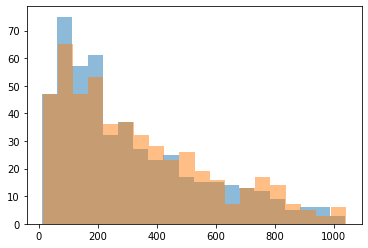

In [11]:
male_data = sales_data[sales_data['Gender'] == 'Male']
female_data = sales_data[sales_data['Gender'] == 'Female']

male_sales = male_data['Total']
female_sales = female_data['Total']

plt.hist(male_sales, bins=20, alpha=0.5)
plt.hist(female_sales, bins=20, alpha=0.5)

plt.show()

In [12]:
## The histogram above seems to indicated that the sales is not a 
## significant difference in the totals of men vs. women shoppers.
## We can test this with a ttest with our hypothesis that the mean
## of male totals = the mean of female totals. The alternate hypothesis
## will be that they are different.

from scipy.stats import ttest_ind

t_stat, pvalue = ttest_ind(male_sales, female_sales)

pvalue

0.11810484577135677

## t-Test conclusion ##

As suspected, the pvalue > 0.05 indicates that we should not reject the null hypothesis which was that the mu_w = mu_m. From this, we would decide wether we need to gather more data, or  we have enough evidence to believe the null hypothesis is true. In this case, I believe our sample sizes are large enough, the histograms suggest the mean is not different, and the t-test also suggests the same. Therefore, in the context of the situation in which this data was gathered, it seems men do not spend more than women and vice versa at this store.

In [ ]:
## Lets test the mean to see if this is a good sample. ##

from scipy.stats import norm
import numpy as np

mean = sales_data['Total'].mean()

data = np.array(sales_data['Total'])

n_bootstrap = 10000

bootstrap_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstrap)]

conf_interval = np.percentile(bootstrap_means, [2.5,97.5])

print(f"95% Confidence Interval: ({conf_interval[0]}, {conf_interval[1]})")
print(mean)

95% Confidence Interval: (307.9490418375, 338.40180491250004)
322.966749


## Boot strap test conclusion ##

By using bootstrapping, a process by which we generate several means by taking random elements from the 'Total' column and taking the means of those datasets, we were able to come up with a 95% confidence interval on the population mean. Our sample falls well within that range. So we can be confident that we have a good sample.